# CS4243 Project

1. Clement Ng
2. Kimberley Tay
3. Wayne Tan

## Scraping dataset

1. Images are scraped from google images, duckduckgo images, and unsplash.
2. They are then manually labelled by us.

In [54]:
#from scraper import main

#main()

## Image Preprocessing

In this step, we will be taking a look at
1. The dataset distribution
2. Normalising of dataset
3. Saving the dataset in a .pt extension for easily reproducible results

In [122]:
from PIL import Image
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import time, os, torch, shutil

### Checking sizes of images

A few things to note:
1. base_folder defines the folder in which all the images are in.
2. It is assumed that the images are in their respective folders based on their labels, with the folder name being the label, and all of them are in base_folder.

In [7]:
base_folder = './dataset-raw'
classes = os.listdir(base_folder)
classes.remove('Unusable')
classes = [int(i) for i in classes]
classes.sort()

In [8]:
def dataset_stats(classes):
    stats = []
    for class_ in classes:
        folder_path = f'{base_folder}/{class_}'
        files = os.listdir(folder_path)
        files.sort()
        for file in files:
            file_path = f'{folder_path}/{file}'
            im = Image.open(file_path)
            size = im.size
            stats.append(size + (min(class_, 11), file_path))
    return np.array(stats)

In [57]:
stats = dataset_stats(classes)

<AxesSubplot:ylabel='Count'>

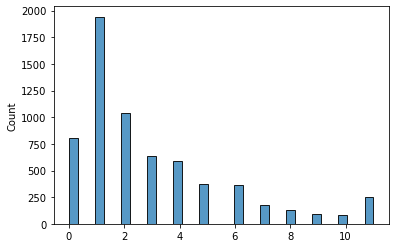

In [10]:
sns.histplot(x=stats[:, 2])

We observe that the amount of dataset for label 1 is much higher than the rest, so the measure we have chosen to adopt here is to deploy undersampling. Furthermore, for the labels >6, the quantity of dataset available is alot less than those <=6, and based on our decision that 6 is a good number to cut off. The label choice we have decided on will be [0, 1, 2, 3, 4, 5, 6, 7-10,>10].

We have determined that it doesnt make a difference whether there 11 or 12 people in an image, and 6 makes for a size suitable for a small group.

In [107]:
def ratio(stats):
    return stats[:, 0:2].max(axis=1) / stats[:, 0:2].min(axis=1)

<AxesSubplot:ylabel='Count'>

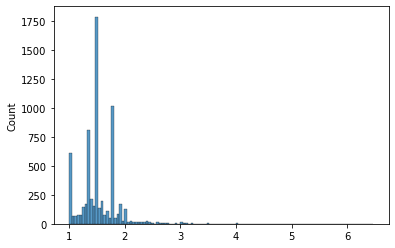

In [106]:
ratios = ratio(stats)
sns.histplot(x=ratios)

Most of the images lie within a boundary of 1 to 2 in aspect ratios, and since we decided to conduct undersampling for majority classes, we will prioritise keeping the images whose aspect ratio lie in this range. In other words, the images whose aspect ratios lie outside this range will be removed with priority.

### Filtering Images

There are images which are very small compared to the size we have have chosen to keep, which is 256x256. So we will filter the images which are less than 1/4 of the desired size for all.

Furthermore, since there is a majority of dataset for label 1 and 2, we have decided to undersample it, in the following order:
1. Selectively filter based on aspect ratio (so that the amount of black box in the dataset would not be too high.
2. Keep filtering until we have approximately equal to the number of datapoints as the next highest class.

In [45]:
def filter_small(stats, size=256):
    crit_met = np.logical_and(
        stats[:, 0] >= size/2, stats[:, 1] >= size/2)
    return stats[crit_met]

In [92]:
stats[(stats[:,2] < 11) & (stats[:, 2] > 6), 2] = 7
stats[stats[:,2] >= 11, 2] = 8

From here on, label 7 will represent 7-10 people, and label 8 will denote > 10 people

(6480, 3)
(6282, 3)


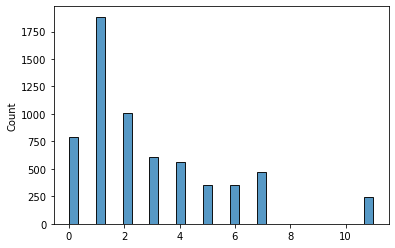

In [93]:
filtered = filter_small(stats)
sns.histplot(x=filtered[:, 2])
print(stats.shape)
print(filtered.shape)

In [44]:
def undersample(stats):
    labels = stats[:, 2].unique()
    count = []
    for label in labels:
        count.append((stats[:, 2] == label).count_nonzero())
    count.sort()
    
    retain = count[-3]
    filtered = []
    for label in labels:
        
        # We scale the aspect ratios so that 1 -> 0, then 
        data = stats[stats[:, 2] == label]
        ratio = (ratio(data) - 1).abs()
        kept = np.argsort(ratio)[: retain]
        filtered.append(data[kept])
    
    filtered = np.concatenate(filtered, axis=0)
    return filtered        

(6480, 3)
(6282, 3)


### Normalising Size of images

1. We will be reading the images, converting them to the same size of 256x256, by scaling while retaining aspect ratio, then padding to a square with 0s.
2. If the original image is larger than 256 on either side, it will be scaled down, else the size will remain the same.
3. The dataset will then be saved to a .pt file, and uploaded to a repository so that it can be reproduced easier, instead of uploading all the images as a dataset.
4. This step will only be performed on a local computer with the dataset and does not need to be reproduced when reproducing the results.
5. If there are requests for the dataset used, please email XXX.

In [58]:
def make_square(im, size):
    x, y = im.size
    factor = x / y
    new_size = (size, size)
    if x < y:
        new_size = (int(factor*size), size)
    elif x > y:
        new_size = (size, int(size / factor))
    new_im = Image.new('RGB', (size, size), color=0)
    new_im.paste(im.resize(new_size),
                 (int((size - new_size[0]) / 2), int((size - new_size[1]) / 2)))
    return new_im

In [11]:
def load_dataset(filtered, size):
    transformer = transforms.ToTensor()
    dataset = []
    labels = []
    for entry in filtered:
        file_path = entry[-1]
        label = entry[-2]
        
        im = Image.open(file_path)
        new_im = make_square(im, size)
        
        dataset.append(transformer(new_im))
        labels.append(label)
        
    dataset = torch.stack(dataset, dim=0)
    labels = torch.tensor(labels)
    return dataset, labels

In [12]:
size = 256
dataset, labels = load_dataset(filtered, size)

In [13]:
dataset.size()

torch.Size([648, 3, 256, 256])

### Saving as a .pt file

In [19]:
total_size = dataset.size()[0]
train_proportion = 0.8
train_size = int(train_proportion*total_size)

shuffled_indices = np.random.permutation(np.arange(total_size))
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

In [ ]:
train_data = dataset[train_indices, :, :, :]
train_labels = labels[train_indices]
test_data = dataset[test_indices, :, :, :]
test_labels = labels[test_indices]

torch.save(train_data, 'train_data.pt')
torch.save(train_labels, 'train_labels.pt')
torch.save(test_data, 'test_data.pt')
torch.save(test_labels, 'test_labels.pt')

In [20]:
torch.save(dataset, 'dataset.pt')
torch.save(labels, 'labels.pt')

## Training of the model

The main goals of this step is to
1. Perform a Vanilla CNN
2. Try to develop a more advanced structure mainly based on the hierarichal features idea taught in class

### Getting dataset

Using the requests module to download the dataset from our repo.

In [ ]:
import requests
base_folder = './dataset'

urls = {
    'train_data': [],
    'train_label': [],
    'test_data': [],
    'test_label': [],
}

def check_dataset(all_urls):
    not_found = {}
    for type_, urls in all_urls.items():
        not_found[type_] = []
        for i, url in enumerate(urls):
            name = f'{type_}_{i+1}'
            if not os.path.exists(f'dataset/{type_}/{name}.pt'):
                not_found[type_].append(url)
    return not_found

def download_dataset(all_urls):
    for type_, urls in all_urls.items():
        for i, url in enumerate(urls):
            r = requests.get(url)
            name = url.split('/')[-1]
            with open(f'./dataset/{type_}/{name}', 'wb') as f:
                f.write(r.content)

not_found = check_dataset(urls)
download_dataset(not_found)

In [ ]:
def load_dataset(type_):
    folder = os.path.join(base_folder, type_)
    files = os.listdir(folder)
    files = [os.path.join(folder, i) for i in files]
    files.sort()
    result = torch.load(files[0])
    for file in files[1:]:
        result = torch.cat((result, torch.load(file)), dim=0)
    return result

In [ ]:
train_data = load_dataset('train_data')
train_label = load_dataset('train_label')
test_data = load_dataset('test_data')
test_label = load_dataset('test_label')

### Vanilla CNN

We will begin with a simple CNN model, with 1 convolutional and linear layer each

In [45]:
import torch.nn as nn
import time

device = torch.device('cuda')

In [70]:
size = np.array([256, 256])

class Vanilla_CNN(nn.Module):
    
    def __init__(self, hidden_dim, output_dim):
        super(Vanilla_CNN, self).__init__()
        
        self.linear_dim = hidden_dim*size.product()
        self.conv = nn.Conv2d(3, hidden_dim, kernel_size=3, padding=1)
        self.linear = nn.Linear(self.linear_dim, output_dim)
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        x = x.view(-1, self.linear_dim)
        x = self.linear(x)
        return x

In [ ]:
def get_error(scores, labels):
    bs = labels.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels != labels)
    num_error = indicator.sum()
    return num_error.float()/bs

In [ ]:
def train_model(model, criterion, train_data, train_label, 
                device, epochs, normalize=True, bs=100, lr=0.2):
    
    start = time.time()
    train_size = train_data.size(0)
    num_batch = (train_size // bs) + 1
    loss = np.zeros([epochs])
    error = np.zeros([epochs])
    
    mean = train_data.mean()
    mean = mean.to(device)
    std = train_data.std()
    std = std.to(device)
    
    for epoch in epochs:
        epoch_loss = 0
        
        if epoch % 10 == 9:
            lr = lr / 2
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        shuffled_indices = torch.randperm(train_size)
        
        for count in range(0, train_size, bs):
            optimizer.zero_grad()
            
            indices = shuffled_indices[count: count+bs]
            minibatch_data = train_data[indices]
            minibatch_label = train_label[indices]
            
            minibatch_data = minibatch_data.to(device)
            minibatch_label = minibatch_label.to(device)
            
            if normalize:
                minibatch_data = (minibatch_data - mean) / std
            
            minibatch_data.requires_grad_()
            
            scores = model(minibatch_data)
            loss = criterion(scores, minibatch_label)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.detach().item()
            epoch_error += get_error(scores, minibatch_label).item()
        
        error[epoch] = epoch_error/num_batch
        loss[epoch] = epoch_loss/num_batch
        elapsed = time.time() - start
        print(f'Epoch = {epoch}, Time = {elapsed:.3f}')
    
    return model, error, loss

In [ ]:
def test_model(model, test_data, test_label, 
               bs=100, normalize=True):
    
    error = 0
    test_size = test_label.size(0)
    num_batches = (test_size // bs) + 1
    
    mean = train_data.mean()
    mean = mean.to(device)
    std = train_data.std()
    std = std.to(device)
    
    for count in range(0, test_size, bs):
        minibatch_data = test_data[count: count+bs]
        minibatch_label = test_label[count: count+bs]
        
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        if normalize:
            minibatch_data = (minibatch_data - mean) / std
        
        scores = model(minibatch_data)
        error += get_error(scores, minibatch_label).item()
    
    error = error / num_batches
    return error